# Anime Synopsis Classifier

**Goal:** Using synopses from the website MyAnimeList.net, I want to be able to predict the genres of any anime in the dataset.

To do this, this notebook will have multiple sections:

#### I. Reading and Cleaning the Data
#### II. Visualize Genre Counts
#### III. Vectorize Text
#### IV. Run several Multilabel Classification algorithms (Naive Bayes, Logistic Regression, Support Vector Machines, Random Forest, K Nearest Neighbors)
#### V. Conclusions

In [1]:
# imports
import glob
import pandas as pd
import sys
import re
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, hamming_loss
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

## I. Reading and Cleaning the Data

All the synopses are stored in text files, thus we must first load them in and do some preprocessing to have cleaner data to work with.

In [2]:
# given a directory that contains the text files, return a Pandas Dataframe that contains the raw data
def load_txt_files(directory):
    
    DATA_FILES = glob.glob(directory+'/*/*.txt')
    i = 0
    output = []
    for file_name in DATA_FILES:
        
        if (i%1000 == 0):
            
            print(i)
        
        name = [file_name.split('\\')[-1][:-4]]
        
        file = open(file_name, encoding='utf-8')
        
        genres = [file.readline().strip()]
        
        synopsis = ''
        lastLine = ''
        invalid = False
        for line in file:
            
            if line.strip() == '':
                
                continue
            
            # how to know if invalid synopsis
            if 'No synopsis yet' in line:
                
                invalid = True
                break
                
            synopsis += line
            lastLine = line
        
        # don't keep anime with invalid synopses
        if invalid:
            
            continue
        
        # remove credits for analysis
        if lastLine != '' and lastLine[0] in {'(':0, '[':0} and lastLine[-1] in {')':0,']':0}:
            
            synopsis = synopsis.replace('\n' + lastLine,'')
        
        synopsis = [synopsis]
        
        output += list(zip(name,genres,synopsis))
        
        file.close()
        i += 1
    
    print('Creating DataFrame...')
    sys.stdout.flush()
    
    df = pd.DataFrame(output, columns = ['Anime', 'Genres', 'Synopsis'])
    
    return df
    

In [3]:
dir_ = '../animeScrape'
df = load_txt_files(dir_)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Creating DataFrame...


In [4]:
df

,Anime,Genres,Synopsis
0,009-1,Action;Mecha;Sci-Fi;Seinen,009-1\nStudios: Ishimori Entertainment\nRating...
1,009-1__R_B,Action;Sci-Fi;Seinen,009-1__R_B\nStudios: add some\nRating: R - 17+...
2,009_Re_Cyborg,Action;Adventure;Mecha;Sci-Fi,009_Re_Cyborg\nStudios: Production I.G\nRating...
3,07-Ghost,Action;Demons;Fantasy;Josei;Magic;Military,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...
4,11-nin_Iru,Action;Adventure;Drama;Mystery;Romance;Sci-Fi;...,11-nin_Iru\nStudios: add some\nRating: PG-13 -...
5,11eyes,Action;Ecchi;Super Power;Supernatural,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...
6,3x3_Eyes,Action;Demons;Fantasy;Horror;Romance,3x3_Eyes\nStudios: Toei Animation\nRating: R -...
7,3x3_Eyes_Seima_Densetsu,Action;Adventure;Demons;Fantasy;Horror;Romance,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...
8,6_Angels,Action;Sci-Fi,6_Angels\nStudios: add some\nRating: R+ - Mild...
9,91_Days,Action;Historical;Drama,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...


### Example Entry:

In [196]:
df['Synopsis'][0]

'009-1\nStudios: Ishimori Entertainment\nRating: R - 17+ (violence & profanity)\nSynopsis: Mylene Hoffman, a beautiful cyborg spy with the codename "009-1" lives in an alternative world where the cold war never ended, continuously on-going for 140 years. The world is split into two factions, the West and the East block. A masquerade of peace between the two is slowly dissipated as the conflict occurs. Through politics, the two factions battle over supremacy over technology to threats of a nuclear attack. Mylene Hoffman, teaming up with three other agent, gets surrounded by deception, chaos and rivalry as she carries out missions assigned by her superiors.'

In [5]:
# get list of genres to make binary columns in dataframe
genres = os.listdir(dir_)

for genre in genres:
    
    df[genre] = df.apply(lambda r: 1 if genre in r['Genres'] else 0,axis = 1)

In [6]:
# don't need genres column anymore
df = df.drop('Genres', axis = 1)
df

,Anime,Synopsis,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Shounen_Ai,Slice_of_Life,Space,Sports,Supernatural,Super_Power,Thriller,Vampire,Yaoi,Yuri
0,009-1,009-1\nStudios: Ishimori Entertainment\nRating...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,009-1__R_B,009-1__R_B\nStudios: add some\nRating: R - 17+...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,009_Re_Cyborg,009_Re_Cyborg\nStudios: Production I.G\nRating...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,07-Ghost,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11-nin_Iru,11-nin_Iru\nStudios: add some\nRating: PG-13 -...,1,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,11eyes,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
6,3x3_Eyes,3x3_Eyes\nStudios: Toei Animation\nRating: R -...,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3x3_Eyes_Seima_Densetsu,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,6_Angels,6_Angels\nStudios: add some\nRating: R+ - Mild...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,91_Days,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## II. Visualize Genre Counts

To get a feel for the distribution, I want to plot the counts of each genre; it's important to visualize the data first!

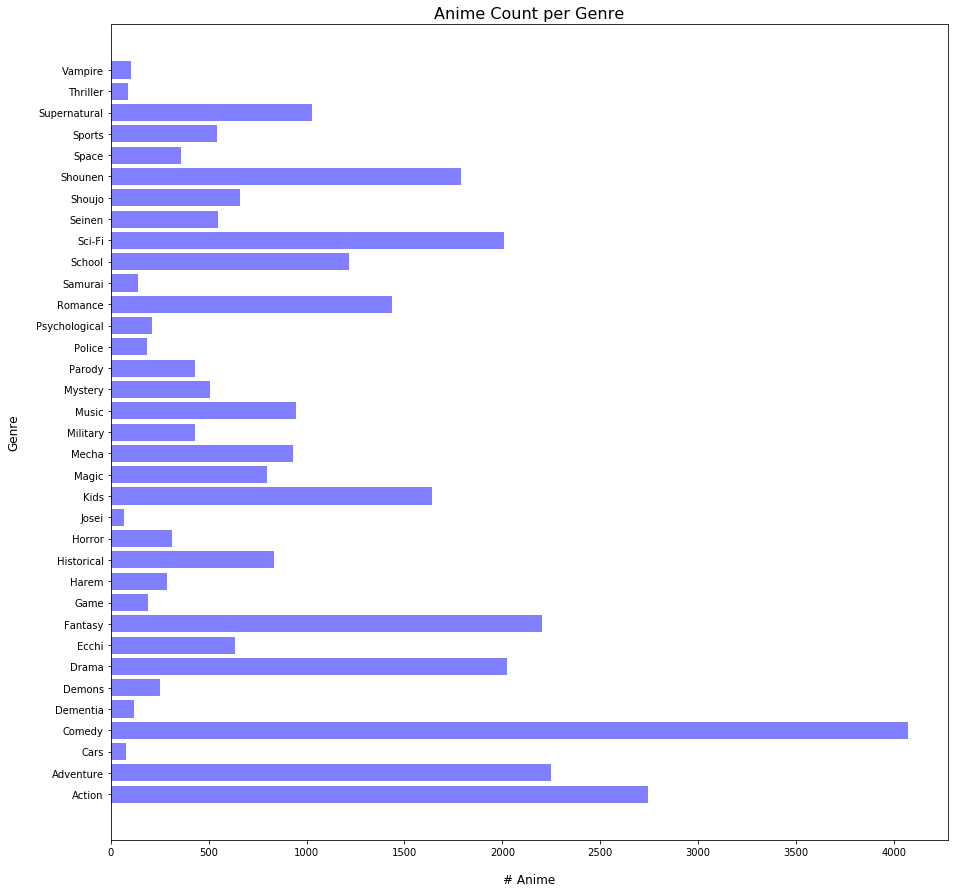

In [7]:
def genrePlot(df,genres):
    
    # get only the binary tags
    df_genres = df[genres]
    
    # we want to collect the genres that have more than 0 anime (can be possible due to preprocessing earlier)
    xlabels = []
    sums = []
    
    for genre in genres:
        
        count = sum(df[genre])
        
        if count>0:
            
            xlabels.append(genre)
            sums.append(count)
            
    # space out labels
    x_pos = np.arange(len(xlabels))
    
    # plotting
    plt.barh(x_pos, sums, align='center', alpha=0.5, color = 'b')
    plt.yticks(x_pos, xlabels)
    plt.xlabel('# Anime', fontsize = 12, labelpad=16)
    plt.ylabel('Genre', fontsize = 12, labelpad=16)
    plt.title('Anime Count per Genre', fontsize = 16)
    plt.show()
    return dict(zip(xlabels,sums))
    
    
genre_counts = genrePlot(df,genres)

** The data looks skewed, so we'll just be looking at the top 10 tags. **

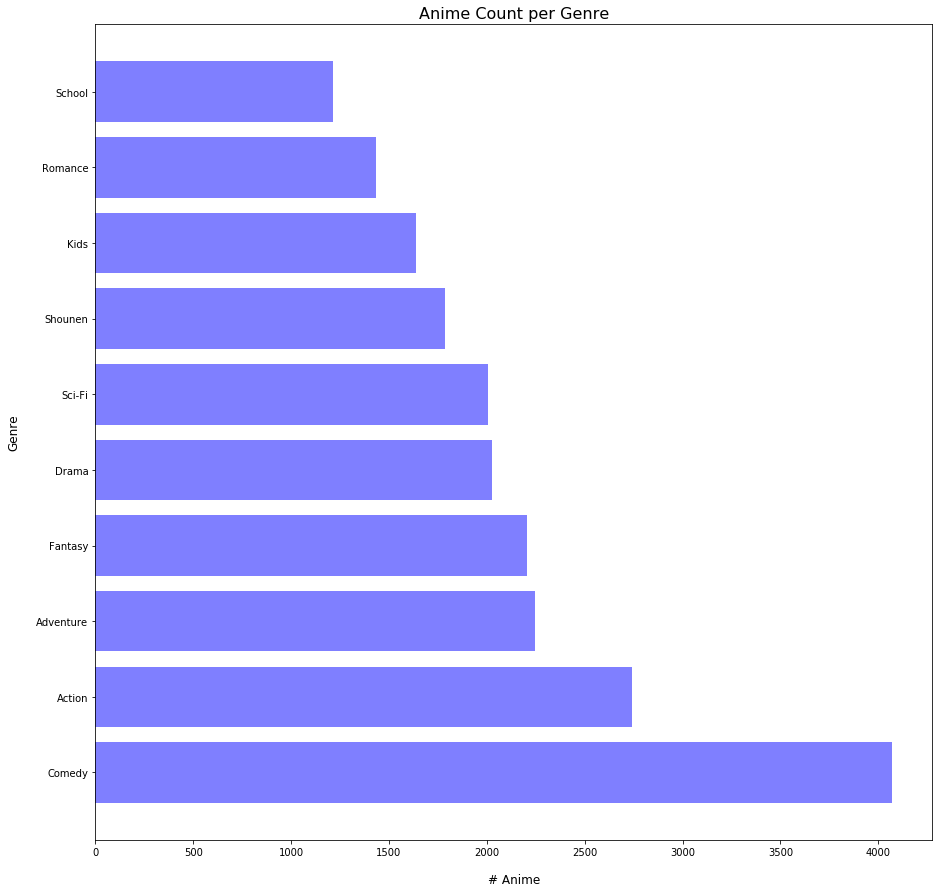

{'Action': 2743,
 'Adventure': 2247,
 'Comedy': 4072,
 'Drama': 2024,
 'Fantasy': 2203,
 'Kids': 1639,
 'Romance': 1435,
 'School': 1216,
 'Sci-Fi': 2006,
 'Shounen': 1787}

In [8]:
sorted_vals = sorted(genre_counts.items(), key=lambda x: x[1], reverse = True)
chosen_genres = [genre for genre,count in sorted_vals[:10]]

genrePlot(df,chosen_genres)

In [9]:
new_columns = ['Anime', 'Synopsis'] + chosen_genres
df = df[new_columns]
df

,Anime,Synopsis,Comedy,Action,Adventure,Fantasy,Drama,Sci-Fi,Shounen,Kids,Romance,School
0,009-1,009-1\nStudios: Ishimori Entertainment\nRating...,0,1,0,0,0,1,0,0,0,0
1,009-1__R_B,009-1__R_B\nStudios: add some\nRating: R - 17+...,0,1,0,0,0,1,0,0,0,0
2,009_Re_Cyborg,009_Re_Cyborg\nStudios: Production I.G\nRating...,0,1,1,0,0,1,0,0,0,0
3,07-Ghost,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...,0,1,0,1,0,0,0,0,0,0
4,11-nin_Iru,11-nin_Iru\nStudios: add some\nRating: PG-13 -...,0,1,1,0,1,1,0,0,1,0
5,11eyes,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...,0,1,0,0,0,0,0,0,0,0
6,3x3_Eyes,3x3_Eyes\nStudios: Toei Animation\nRating: R -...,0,1,0,1,0,0,0,0,1,0
7,3x3_Eyes_Seima_Densetsu,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...,0,1,1,1,0,0,0,0,1,0
8,6_Angels,6_Angels\nStudios: add some\nRating: R+ - Mild...,0,1,0,0,0,1,0,0,0,0
9,91_Days,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...,0,1,0,0,1,0,0,0,0,0


### Note

So that we don't have to redo the above process everytime, we can pickle our final dataframe:

In [102]:
# serialize dataframe for future use
df.to_pickle('anime_df.pkl')

In [2]:
# read in dataframe
df = pd.read_pickle('anime_df.pkl')

## III. Vectorize Text

In [3]:
X = np.asarray(df['Synopsis'])
y = np.asarray(df[df.columns.difference(['Anime','Synopsis'])])

sf = StratifiedShuffleSplit(n_splits = 1, train_size = .8, test_size = .2, random_state = 7)

# separate into 80% training 20% testing set
for train_idx, test_idx in sf.split(X,y):
    
    X_train = X[train_idx]
    X_test = X[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]

### Tokenize Text

In [4]:
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
import re

regex = re.compile('[^ \w]', re.U)

def tokenize(text):
    
    text = regex.sub('', text).lower().replace(',', ' ').replace('\n', ' ')
    
    tokens = np.asarray(nltk.word_tokenize(text))
    
    valid = [s not in ENGLISH_STOP_WORDS for s in tokens]
    
    tokens = tokens[valid]
    
    lemm = []
    
    lemmatizer = WordNetLemmatizer()
    
    for token in tokens:
        
        lemm.append(lemmatizer.lemmatize(token))
    
    
    return lemm

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer = tokenize, ngram_range = (1,3), max_features = 50000)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x0000020501864EA0>, use_idf=True,
        vocabulary=None)

In [6]:
with open('vect.pkl','wb') as f:
    
    pickle.dump(vectorizer,f)

In [7]:
with open('vect.pkl','rb') as f:
    
    vectorizer = pickle.load(f)

In [8]:
pd.DataFrame(vectorizer.get_feature_names()[1000:1100])

,0
0,75
1,75 september
2,75 september 22nd
3,78
4,78 shown
5,7minute
6,7th
7,7th dvdbd
8,7th hokage
9,7th manga


In [9]:
X_train_tf = vectorizer.transform(X_train)
X_test_tf = vectorizer.transform(X_test)

### Save Transformed Vectors

In [10]:
with open('X_train_tf.pkl', 'wb') as f:
    pickle.dump(X_train_tf, f)
    
with open('X_test_tf.pkl', 'wb') as f:
    pickle.dump(X_test_tf, f)
    
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train,f)

with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test,f)

### Load Transformed Vectors

In [11]:
with open('X_train_tf.pkl', 'rb') as f:
    X_train_tf = pickle.load(f)

with open('X_test_tf.pkl', 'rb') as f:
    X_test_tf = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

### Visualize Clusters

In [37]:
from scipy.sparse import vstack

X_tf = vstack((X_train_tf, X_test_tf))

In [44]:
ls = TruncatedSVD(n_components = 2)
ls.fit(X_tf)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [45]:
X_two = ls.transform(X_tf)
X_two

array([[ 0.19953049, -0.21182545],
       [ 0.06710267, -0.09785829],
       [ 0.0439894 , -0.06780042],
       ..., 
       [ 0.05629894, -0.08100145],
       [ 0.05804663, -0.04442929],
       [ 0.0906653 , -0.15380577]])

In [50]:
y = np.vstack((y_train,y_test))

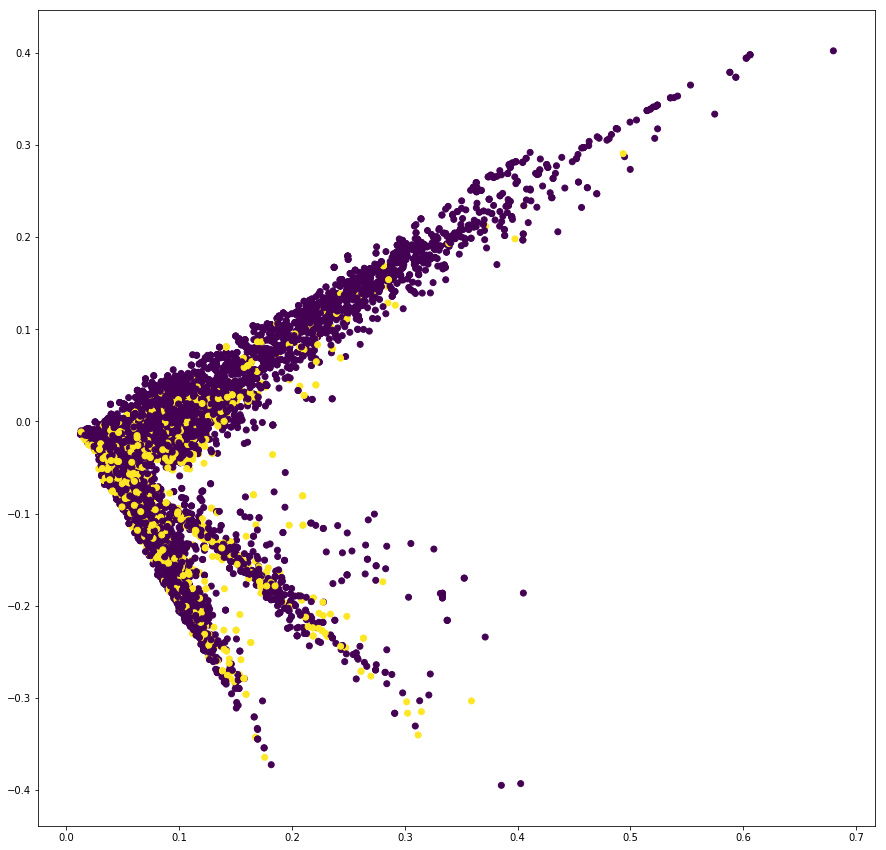

In [70]:
plt.scatter(X_two[:,0],X_two[:,1], c = y[:,0])
plt.show()

## IV. Test Different Classifiers

In this section we'll be testing different multi-label classifiers by performing grid search to optimize each parameter and returning the best results.

**Setting up GridSearchCV parameters**

In [12]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

f1_scorer = make_scorer(f1_score, average = 'weighted')

In [13]:
kwargs = {'scoring': f1_scorer, 'cv': KFold(5)}

In [14]:
scores = {'log_reg': {'F1': 0, 'Precision': 0, 'Recall': 0, 'Hamming': 0},
          'naive_bayes': {'F1': 0, 'Precision': 0, 'Recall': 0, 'Hamming': 0},
          'svm': {'F1': 0, 'Precision': 0, 'Recall': 0, 'Hamming': 0},
          'random_forest': {'F1': 0, 'Precision': 0, 'Recall': 0, 'Hamming': 0},
          'knn': {'F1': 0, 'Precision': 0, 'Recall': 0, 'Hamming': 0}}

In [15]:
def reportMetrics(model, y_pred, y_actual):
    f1 = f1_score(y_actual,y_pred, average = 'weighted')
    precision = precision_score(y_actual,y_pred, average = 'weighted')
    recall = recall_score(y_actual,y_pred, average = 'weighted')
    hamming = hamming_loss(y_actual,y_pred)
    
    scores[model]['F1'] = f1
    scores[model]['Precision'] = precision
    scores[model]['Recall'] = recall
    scores[model]['Hamming'] = hamming
    
    print('Accuracy: ' + str(accuracy_score(y_actual,y_pred)))
    print('F1 Score: ' + str(f1))
    print('Precision Score: ' + str(precision))
    print('Recall Score: ' + str(recall))
    print('Hamming Loss: ' + str(hamming))

### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

parameters = [{'estimator__C' : [10,1,1e-1], 'estimator__penalty' : ['l1', 'l2']}]
log_reg = LogisticRegression()
clf = GridSearchCV(OneVsRestClassifier(log_reg), parameters, **kwargs)

In [19]:
clf.fit(X_train_tf,y_train)

c:\users\kurti\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\kurti\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\kurti\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\kurti\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__C': [10, 1, 0.1], 'estimator__penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=0)

In [237]:
# save log_reg results
with open('log_reg.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [16]:
# read log_reg results
with open('log_reg.pkl', 'rb') as f:
    clf = pickle.load(f)

In [20]:
y_test_pred = clf.predict(X_test_tf)
reportMetrics('log_reg', y_test_pred , y_test)

Accuracy: 0.589388145315
F1 Score: 0.788668284779
Precision Score: 0.875977364962
Recall Score: 0.722031571723
Hamming Loss: 0.07968451242829828


### 2) Naive Bayes

In [244]:
parameters = [{'estimator__alpha' : [100,10,1,1e-1,1e-2,1e-3,1e-4]}]
nb = MultinomialNB()
clf = GridSearchCV(OneVsRestClassifier(nb), parameters, **kwargs)

In [245]:
clf.fit(X_train_tf,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'estimator__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [22]:
y_pred = clf.predict(X_test_tf)
reportMetrics('naive_bayes', y_pred, y_test)

Accuracy: 0.52103250478
F1 Score: 0.748029057956
Precision Score: 0.853510447131
Recall Score: 0.673987645848
Hamming Loss: 0.09316443594646272


In [247]:
# save naive bayes results
with open('bayes.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [21]:
# read naive bayes results
with open('bayes.pkl', 'rb') as f:
    clf = pickle.load(f)

### 2) Support Vector Machines

In [224]:
parameters = [{'estimator__C': [10,1,1e-1,1e-2], 'estimator__gamma': [1e-3, 1e-4],
               'estimator__kernel': ['linear', 'poly']}]
               
svc = SVC()
clf = GridSearchCV(OneVsRestClassifier(svc), parameters, **kwargs)

In [225]:
clf.fit(X_train_tf,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'estimator__C': [10, 1, 0.1, 0.01], 'estimator__gamma': [0.001, 0.0001], 'estimator__kernel': ['linear', 'poly']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [226]:
# save SVC results
with open('SVC.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [14]:
# load classifier
with open('SVC.pkl', 'rb') as f:
    clf = pickle.load(f)

In [15]:
y_pred = clf.predict(X_test_tf)

In [16]:
reportMetrics('svm', y_pred,y_test)

Accuracy: 0.604684512428
F1 Score: 0.788493307715
Precision Score: 0.817394392522
Recall Score: 0.762983299016
Hamming Loss: 0.08494263862332696


### 3) Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
forest_params = [{'estimator__n_estimators': [20,30,40], 'estimator__max_features': ['auto', 'log2'],
               'estimator__bootstrap': [False, True]}]

rf = RandomForestClassifier()
ovr = OneVsRestClassifier(rf)
clf = GridSearchCV(ovr, forest_params)

In [276]:
clf.fit(X_train_tf, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__n_estimators': [20, 30, 40], 'estimator__max_features': ['auto', 'log2'], 'estimator__bootstrap': [False, True]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [277]:
clf.best_estimator_

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=1)

In [20]:
y_pred = clf.predict(X_test_tf)

In [21]:
reportMetrics('random_forest',y_pred,y_test)

Accuracy: 0.604206500956
F1 Score: 0.751078035583
Precision Score: 0.920013880596
Recall Score: 0.640814458934
Hamming Loss: 0.0874282982791587


In [280]:
# save RandomForest results
with open('rf.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [19]:
# load classifier
with open('rf.pkl', 'rb') as f:
    clf = pickle.load(f)

### 4) K-Nearest Neighbors

In [23]:
knn_params = [{'estimator__n_neighbors': [3,5,7,9,12]}]
model = KNeighborsClassifier()
ovr = OneVsRestClassifier(model)
clf = GridSearchCV(ovr, knn_params, **kwargs)

In [24]:
clf

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__n_neighbors': [3, 5, 7, 9, 12]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=0)

In [26]:
clf.fit(X_train_tf,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__n_neighbors': [3, 5, 7, 9, 12]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=0)

In [27]:
y_pred=clf.predict(X_test_tf)

In [28]:
reportMetrics('knn',y_pred,y_test)

Accuracy: 0.391491395793
F1 Score: 0.627354290728
Precision Score: 0.697800348194
Recall Score: 0.576069549302
Hamming Loss: 0.14077437858508604


In [29]:
# save knn results
with open('knn.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [30]:
# load knn classifier
with open('knn.pkl', 'rb') as f:
    clf = pickle.load(f)